# 3.1. Diseño de la base de datos
Se desea implementar una serie de funciones para contruir nuestra BD clave-valor que imite el funcionamiento de Twitter.
Funciones:
- nuevo_usuario
- nuevo_follower
- nuevo_following
- seguir
- nuevo_post

## Configuración

En primer lugar vamos a necesitar gestionar las propiedades de conexión. Para conectarnos a REDIS necesitamos 

In [1]:
import configparser

# Wrapper del configparser de python.
class RedisConfig(object):
    
    def __init__(self, config_file=None):
        self._config = configparser.ConfigParser()
        if config_file is not None :
            self._config.read(config_file)
    
    @property
    def host(self):
        return self._config['redis']['REDIS_HOST']
    @property
    def port(self):
        return self._config['redis']['REDIS_PORT']
    @property
    def password(self):
        return self._config['redis']['REDIS_PWD']
    @property
    def db(self):
        return self._config['redis']['REDIS_DB']
    

In [2]:
# Sustituir propiedades por las del propias de cada uno.
# En mi caso son localhost, 6379, '' y 1.
! test -f redis_config.ini && rm redis_config.ini && echo 'Se ha borrado redis_config.ini'
! touch redis_config.ini
! echo '[redis]' >> redis_config.ini
! echo 'REDIS_HOST=localhost' >> redis_config.ini
! echo 'REDIS_PORT=6379' >> redis_config.ini
! echo 'REDIS_PWD=' >> redis_config.ini
! echo 'REDIS_DB=7' >> redis_config.ini
! echo
! cat redis_config.ini
! echo
! echo 'redis_config.ini creado en: '$(pwd)

Se ha borrado redis_config.ini

[redis]
REDIS_HOST=localhost
REDIS_PORT=6379
REDIS_PWD=
REDIS_DB=7

redis_config.ini creado en: /Users/adzarei/Documents/UNED/ING_CIENC_DATOS/projects/GAI/redis/src/notebooks


In [3]:
config = RedisConfig('redis_config.ini') 
print(config.host)
print(config.port)
print(config.password)
print(config.db)

localhost
6379

7


## Modelo
Ahora vamos a diseñar los objetos que necesitamos para el dominio. Necesitaremos:
- Usuario
- Post

## Redis API  \#1
Es hora de implementar los métodos que usaremos para la carga de datos:
- nuevo_usuario(username)
- nuevo_follower(username, follower, timestamp)
- nuevo_following(username, followee, timestamp)
- seguir(username, followee, timestamp)
- nuevo_post(username, body, timestamp)

In [4]:
import redis
r = redis.Redis(host=config.host, port=config.port, password=config.password, db=config.db)

In [5]:
def nuevo_usuario(username):
    if r.hget('users', username) is None:
        id = r.incr('user_id')
        r.hmset('users', {username:id})

In [6]:
def _nuevo_follower(username, follower, timestamp):
    
    usr_id = r.hget('users', username)
    follower_id = r.hget('users', follower)
    
    if usr_id is None or follower_id is None:
        return False
    
    usr_id = usr_id.decode('utf-8')
    follower_id = follower_id.decode('utf-8')
    
    r.zadd('ts_follower_of:' + usr_id, {follower_id : timestamp})
    r.sadd('follower_of:' + usr_id, follower_id)
    
    return True

In [7]:
def _nuevo_following(username, followee, timestamp):
    usr_id = r.hget('users', username)
    followee_id = r.hget('users', followee)
    
    if usr_id is None or followee_id is None:
        return
    
    usr_id = usr_id.decode('utf-8')
    followee_id = followee_id.decode('utf-8')
    
    r.zadd('ts_followee_of:' + usr_id, {followee_id : timestamp})

In [8]:
def seguir(username, followee, timestamp):
    res = _nuevo_follower(followee, username, timestamp)
    # Si el _nuevo_follower devuelve falso, no se ejecuta _nuevo_following.
    res = res and _nuevo_following(username, followee, timestamp)
    return res

In [9]:
def nuevo_post(username, body, timestamp):
    usr_id = r.hget('users', username)
    
    if usr_id is None:
        return
    
    usr_id = usr_id.decode('utf-8')
    
    post_id = r.incr('post_id')
    followers = r.smembers('follower_of:' + usr_id)
    
    # Creamos el post
    r.hmset('post:' + str(post_id), {'id' : post_id, 'timestamp' : timestamp, 'body' : body})
    
    # Guardamos la referencia para el usuario
    r.zadd('ts_timeline:' + usr_id, {post_id : timestamp})
    
    # Guardamos la referencia para los followees del usuario.
    for follower in followers:
        follower_id = follower.decode("utf-8")
        r.zadd('ts_timeline:' + follower_id, {post_id : timestamp})
        

    

## Pruebas

nuevo_usuario('zap')
nuevo_usuario('Maria')
nuevo_usuario('patri')
nuevo_usuario('conhic')

r.hget('users', 'zap').decode("utf-8")

seguir('Maria', 'zap','001')
seguir('zap', 'patri' ,'003')
seguir('patri','conhic' ,'005')
seguir('conhic','Maria' ,'005')
seguir('conhic','zap' ,'007')
seguir('patri','zap' ,'009')

r.smembers('follower_of:1')

r.smembers('follower_of:2')

r.smembers('follower_of:3')

r.smembers('follower_of:4')

nuevo_post('zap'  , 'test esto es un test - MSG1', '001') # 1
nuevo_post('zap'  , 'test esto es un test - MSG2', '006') # 2
nuevo_post('zap'  , 'test esto es un test - MSG3', '007') # 3
nuevo_post('zap'  , 'test esto es un test - MSG4', '008') # 4
nuevo_post('patri', 'test esto es un test - MSG5', '009') # 5

# zap
r.zscan('ts_timeline:1', 0)

# Maria
r.zscan('ts_timeline:2', 0)

# Patri
r.zscan('ts_timeline:3', 0)

# Conhic
r.zscan('ts_timeline:1', 0)

r.hgetall('post:5')

for msg in r.zrangebyscore('ts_timeline:1',6,8):
    post_id = msg.decode('utf-8')
    print(r.hget('post:' + post_id, 'body'))

r.zrangebyscore('ts_timeline:2',0,10, withscores=True)

r.zscore('ts_timeline:1', 5)

# 3.2. Conjunto de datos
Se desea cargar nuestra BD con los datos alojados en los ficheros: “twitter_sample.csv” y “relations.csv”

#### twitter_sample.csv
Contiene 111 tweets.
Estructura: user, post_time y tweet_content.
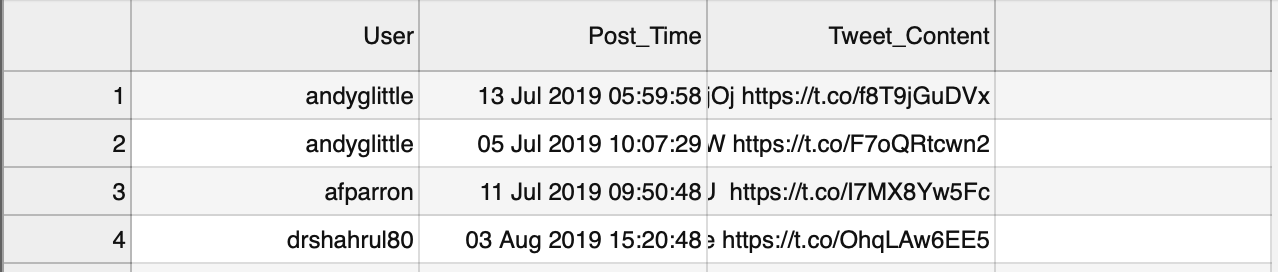


#### relations.csv
Contiene 22 relaciones.
Estructura: user, follows, following_time.
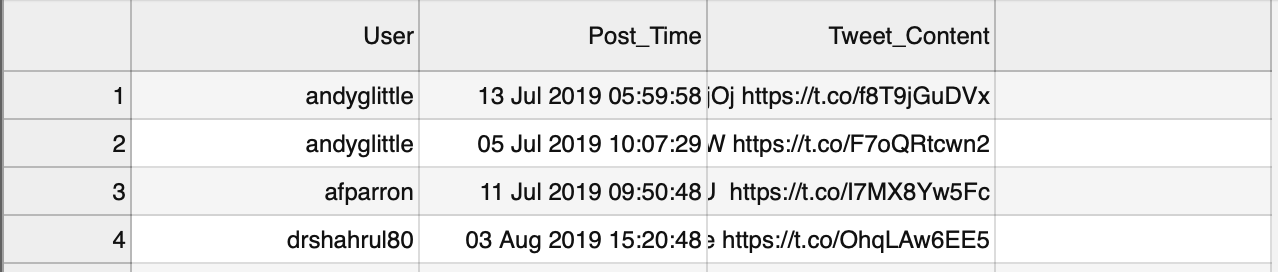



Nota: 
- En primer lugar debemos cargar topos los usuarios.
- En segundo lugar debemos cargar las relaciones
- En tercer lugar cargaremos los posts.

In [161]:
import pandas as pd
import numpy as np
import os

tweets_path = os.path.join('data','twitter_sample.csv')
relation_path = os.path.join('data','relations.csv')

tweets = pd.read_csv(filepath_or_buffer=tweets_path, header=0, sep=',', quotechar='"', encoding='utf-8')
relation = pd.read_csv(filepath_or_buffer=relation_path, header=0, sep=',', encoding='utf-8')

In [162]:
tweets.columns

Index(['User', 'Post_Time', 'Tweet_Content', 'Unnamed: 3'], dtype='object')

In [163]:
# Hay algún Nan en la columna User. Tendremos que tratarlo a parte.
tweets['User'].unique()

array(['andyglittle', 'afparron', 'drshahrul80', 'karin_stowell',
       'cathcooney', 'dkalnow', 'alkhalilkouma', 'seers_helen',
       'hanyshita', nan, 'roxanefeller', 'animalhealthEU', 'charleskod'],
      dtype=object)

In [164]:
# Hay una línea que no tiene nombre de usuario. La descartamos...
tweets[tweets['User'].isna()]

,User,Post_Time,Tweet_Content,Unnamed: 3
14,NaN,02 Jul 2019 20:56:39,@stemagno74 @wcrfint @macmillancancer @NIHRres...,NaN


In [165]:
tweets.drop(index=14, inplace=True)
tweets[tweets['User'].isna()]

,User,Post_Time,Tweet_Content,Unnamed: 3


In [166]:
# No tenemos Nan en Post_time.
tweets[tweets['Post_Time'].isna()]

,User,Post_Time,Tweet_Content,Unnamed: 3


In [167]:
# No tenemos Nan en Tweet_Content.
tweets[tweets['Tweet_Content'].isna()]

,User,Post_Time,Tweet_Content,Unnamed: 3


In [168]:
tweets.head()

,User,Post_Time,Tweet_Content,Unnamed: 3
0,andyglittle,13 Jul 2019 05:59:58,We've loved being motivated by the stories of ...,NaN
1,andyglittle,05 Jul 2019 10:07:29,Thanks for the shout-out on our #MorethanMedic...,NaN
2,afparron,11 Jul 2019 09:50:48,#MorethanMedicine — Our Story via ⁦@animalhea...,NaN
3,drshahrul80,03 Aug 2019 15:20:48,We hope to get some lovely weather on our annu...,NaN
4,karin_stowell,04 Aug 2019 14:20:46,This is what #MoreThanMedicine is about. Love ...,NaN


In [169]:
# Hay 2 líneas cuyo Tweet_Content al contener ',' y no estar envuelto por '"' se separa en una columna mas.
tweets[tweets['Unnamed: 3'].notna()]['Unnamed: 3']

19     join us on our annual sponsored 6 mile walk o...
24     environmental factors) has the possibility to...
Name: Unnamed: 3, dtype: object

In [170]:
# Cambiamos los Nan por ''.
tweets['Unnamed: 3'] = tweets['Unnamed: 3'].fillna('')

# Unimos las 2 columnas.
tweets['Tweet_Content'] = tweets['Tweet_Content'] + tweets['Unnamed: 3']

# Borramos la última columna.
tweets.drop(columns='Unnamed: 3', inplace=True)
tweets.head()

,User,Post_Time,Tweet_Content
0,andyglittle,13 Jul 2019 05:59:58,We've loved being motivated by the stories of ...
1,andyglittle,05 Jul 2019 10:07:29,Thanks for the shout-out on our #MorethanMedic...
2,afparron,11 Jul 2019 09:50:48,#MorethanMedicine — Our Story via ⁦@animalhea...
3,drshahrul80,03 Aug 2019 15:20:48,We hope to get some lovely weather on our annu...
4,karin_stowell,04 Aug 2019 14:20:46,This is what #MoreThanMedicine is about. Love ...


In [171]:
relation.columns

Index(['User', 'Follows', 'Following_Time'], dtype='object')

In [172]:
relation.head()

,User,Follows,Following_Time
0,roxanefeller,cathcooney,13 Jun 2019 05:59:58
1,andyglittle,charleskod,14 Jul 2019 10:07:29
2,andyglittle,seers_helen,18 Jul 2019 09:50:48
3,andyglittle,karin_stowell,31 Aug 2019 15:20:48
4,hanyshita,andyglittle,12 Jul 2019 14:20:46


In [179]:
users = tweets['User'].unique()
users

array(['andyglittle', 'afparron', 'drshahrul80', 'karin_stowell',
       'cathcooney', 'dkalnow', 'alkhalilkouma', 'seers_helen',
       'hanyshita', 'roxanefeller', 'animalhealthEU', 'charleskod'],
      dtype=object)

### Insertamos los usuarios

In [178]:
for user in users:
    nuevo_usuario(user)

In [184]:
r.hget('users', 'andyglittle').decode("utf-8")

'5'

In [183]:
r.hget('users', 'charleskod').decode("utf-8")

'16'

## Función para convertir de a timestamp

In [209]:
from datetime import datetime

date_format = '%d %b %Y %H:%M:%S'

def date2ts(date_string):
    return datetime.strptime(date_string, date_format).timestamp()
    
def ts2date(ts):
    return datetime.fromtimestamp(ts).strftime(date_format)

# Probamos la función
print(date2ts('12 Jul 2019 14:20:46'))
print(ts2date(1562934046.0))

1562934046.0
12 Jul 2019 14:20:46
